In [135]:
from initialization import Location
from initialization import Grid
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Base Model

In [136]:

# Parameters
beta = 0.3 
mu = 0.1  
population = 1000 
initial_infected = 1  
initial_susceptible = population - initial_infected  
initial_recovered = 0 
days = 100  

# Create arrays to store the results
susceptible = np.zeros(days)
infectious = np.zeros(days)
recovered = np.zeros(days)

# Initialize the initial conditions
susceptible[0] = initial_susceptible
infectious[0] = initial_infected
recovered[0] = initial_recovered

# Simulate the SIR model
for day in range(1, days):
    new_infections = beta * susceptible[day - 1] * infectious[day - 1] / population
    new_recoveries = mu * infectious[day - 1]

    susceptible[day] = susceptible[day - 1] - new_infections
    infectious[day] = infectious[day - 1] + new_infections - new_recoveries
    recovered[day] = recovered[day - 1] + new_recoveries



# Mobility-Based Model

In [137]:

def get_other_loc_params(grid,loc):
    infections = 0
    total_connections = 0
    for j in loc.connections:
        if grid.map[j].n != 0:
            infections += loc.connections[j] * (grid.map[j].i / grid.map[j].n)
            total_connections += loc.connections[j]
    
    return infections, total_connections

In [166]:
def dynamic_alpha():
    # Parameters
    beta = 0.3 #rate of infection *CHANGE LATER MAYBE*
    mu = 0.1 #rate of recovery *CHANGE LATER MAYBE*
    N = 1000 
    n_locations=10
    days = 100
    alphas = np.arange(0.1,1.1,0.1)
    alpha=0.5
    trials=10

    alpha_sir = {}
    for alpha in alphas:

        # Create arrays to store the results
        susceptible = np.zeros(days)
        infectious = np.zeros(days)
        recovered = np.zeros(days) 
        for trial in range(trials):
    
            #Initialize grid and locations
            grid = Grid(n_locations, N, alpha, beta, mu)

            #initialize random starting location
            grid.random_orgin()

            for day in range(days):
                for loc in grid.map:
                    if loc.n != 0:
                        infections, total_connections = get_other_loc_params(grid, loc)
                        
                        new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))
                        
                        new_recoveries = (mu * loc.i) / loc.n

                        loc.s = loc.s - new_infections
                        loc.i = loc.i + new_infections - new_recoveries
                        loc.r = loc.r + new_recoveries

                        susceptible[day] += loc.s
                        infectious[day] += loc.i
                        recovered[day] += loc.r

                #susceptible[day] /= N
                #infectious[day] /= N
                #recovered[day] /= N

        susceptible = [day / (trials*N) for day in susceptible]
        infectious = [day / (trials*N) for day in infectious]
        recovered = [day / (trials*N) for day in recovered]

        susceptible.insert(0,1)
        infectious.insert(0,1/N)
        recovered.insert(0,0)

        alpha_sir[alpha] = [susceptible, infectious, recovered]
    return alpha_sir





In [167]:
dynamic_alpha_results = dynamic_alpha()

In [168]:
dynamic_alpha_results

{0.1: [[1,
   0.998692854837307,
   0.998298306410924,
   0.997793026405228,
   0.9971478736462399,
   0.996326609424616,
   0.9952844514748489,
   0.9939664989650521,
   0.9923060723773189,
   0.9902230353772536,
   0.9876221981702457,
   0.9843919116907668,
   0.9804029037928732,
   0.9755072675125933,
   0.969537353741016,
   0.9623043167844373,
   0.9535964144417579,
   0.9431778968815122,
   0.9307900544767886,
   0.9161560569098354,
   0.8989902275581618,
   0.879011057768775,
   0.8559573468013008,
   0.8296095442652124,
   0.799821833240803,
   0.766569661965578,
   0.7300083560756473,
   0.6905244266925668,
   0.6487533406673116,
   0.605545569849417,
   0.5618838840560174,
   0.5187744545366356,
   0.4771399064210412,
   0.4377348757693233,
   0.40109373597246734,
   0.36751295705496656,
   0.3370668935825128,
   0.309652438386582,
   0.28505308251145245,
   0.2630075552322053,
   0.24326581490505828,
   0.22561901186950162,
   0.2099000719952757,
   0.19596334128641416,
   0

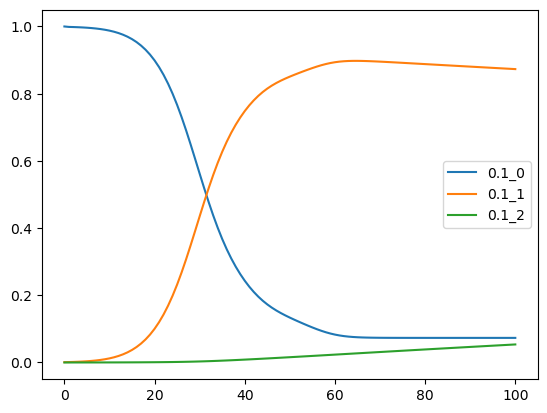

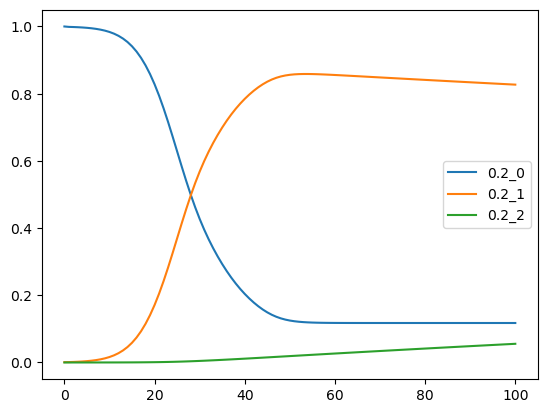

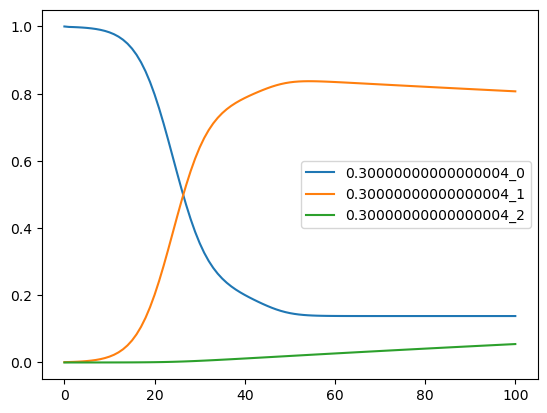

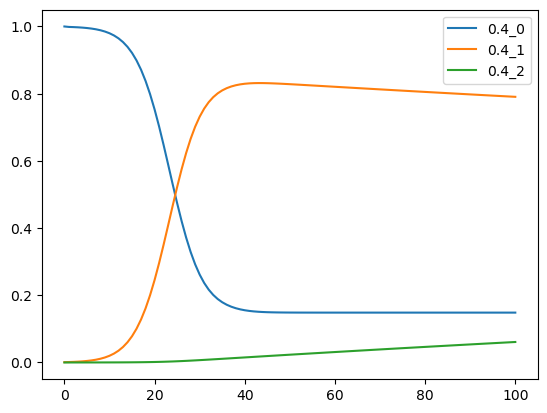

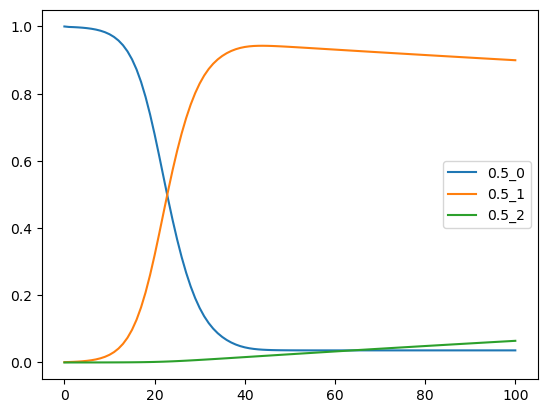

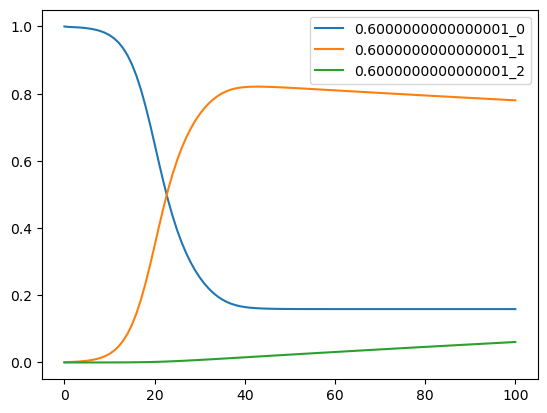

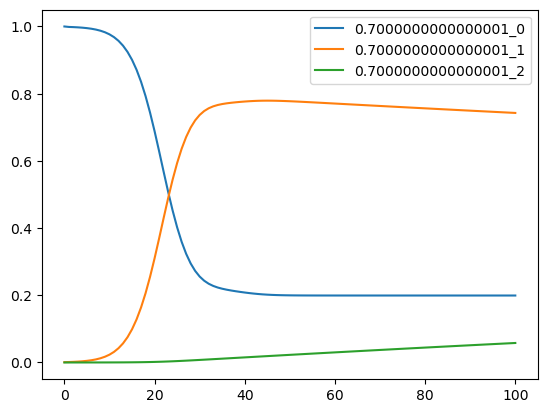

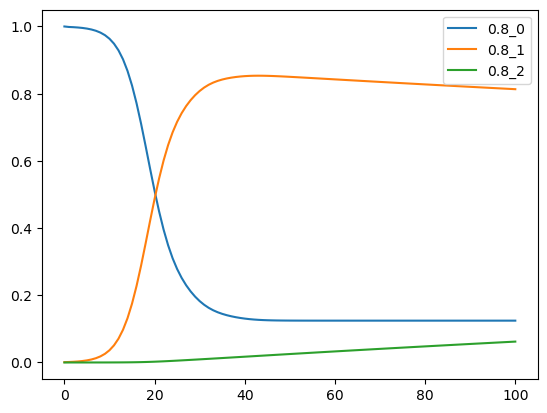

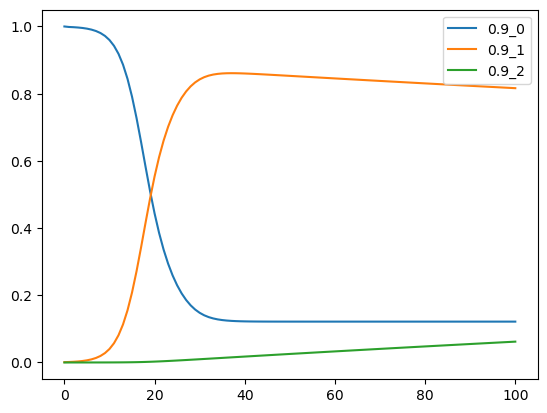

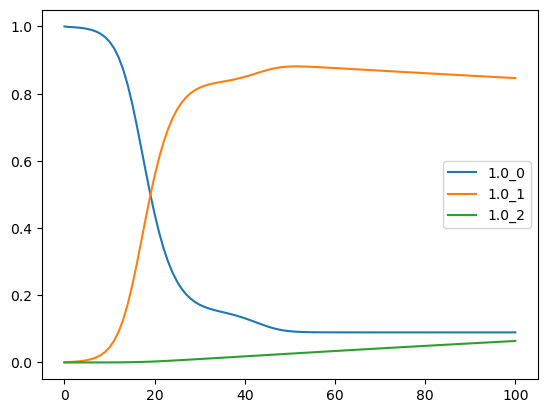

In [169]:
for key, values in dynamic_alpha_results.items():
    plt.figure()
    for sublist in values:
        plt.plot(sublist, label=f'{key}_{values.index(sublist)}')

    plt.legend()
    
plt.show()

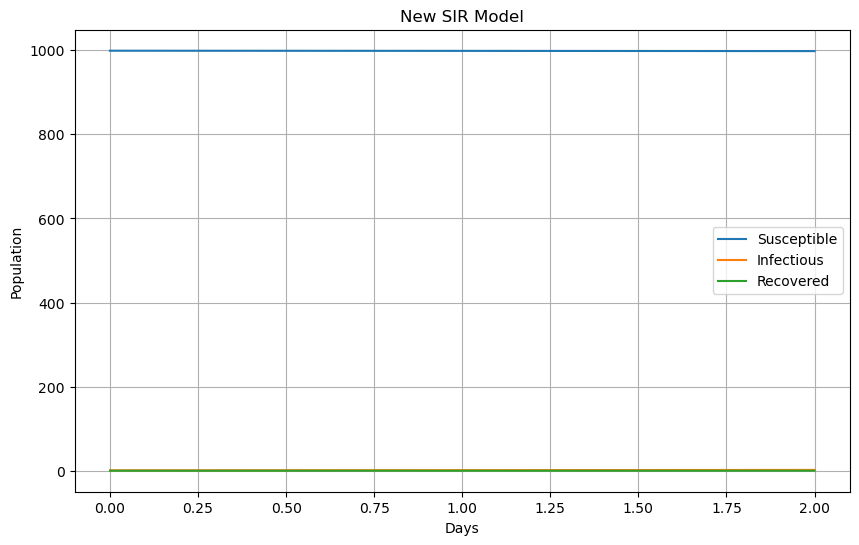

In [140]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(susceptible, label="Susceptible")
plt.plot(infectious, label="Infectious")
plt.plot(recovered, label="Recovered")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.title("New SIR Model")
plt.grid(True)
plt.show()